In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy import stats
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

%matplotlib inline

# Load Dataset

In [2]:
offers = pd.read_csv("raw_data\offers.csv")
offers.sort_values(by="offer_type")

,offer_id,offer_type,difficulty,reward,duration,channels
0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,10,7,"['email', 'mobile', 'social']"
1,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,10,5,"['web', 'email', 'mobile', 'social']"
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,5,7,"['web', 'email', 'mobile']"
8,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5,5,"['web', 'email', 'mobile', 'social']"
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,20,5,10,"['web', 'email']"
5,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,7,3,7,"['web', 'email', 'mobile', 'social']"
6,fafdcd668e3743c1bb461111dcafc2a4,discount,10,2,10,"['web', 'email', 'mobile', 'social']"
9,2906b810c7d4411798c6938adc9daaa5,discount,10,2,7,"['web', 'email', 'mobile']"
2,3f207df678b143eea3cee63160fa8bed,informational,0,0,4,"['web', 'email', 'mobile']"
7,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,3,"['email', 'mobile', 'social']"


In [3]:
events = pd.read_csv("raw_data\events.csv")
events.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [4]:
customers = pd.read_csv("raw_data\customers.csv")
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,20170715,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,20170509,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,20170804,NaN,118,NaN


In [5]:
#make date joined to a date data type
customers["became_member_on"] = customers["became_member_on"].astype(str)
customers["became_member_on"] = pd.to_datetime(customers["became_member_on"], format="%Y%m%d")
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN


In [6]:
# dataframe of the the blank gender and income and 118 years old
df_empty = customers[
    (customers["gender"].isna())
    & (customers["income"].isna())
    & (customers["age"] == 118)
]

df_empty.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN
6,8ec6ce2a7e7949b1bf142def7d0e0586,2017-09-25,NaN,118,NaN
7,68617ca6246f4fbc85e91a2a49552598,2017-10-02,NaN,118,NaN


In [7]:
# customers with full details
df_other_customers = customers[~customers["customer_id"].isin(df_empty["customer_id"].values)]
df_other_customers.head()

,customer_id,became_member_on,gender,age,income
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
5,e2127556f4f64592b11af22de27a7932,2018-04-26,M,68,70000.0
8,389bc3fa690240e798340f5a15918d5c,2018-02-09,M,65,53000.0
12,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,M,58,51000.0


In [8]:
print(f"Customers Dataset Size: \nOriginal: {customers.shape} \nMissing Details: {df_empty.shape} \nWith Full Details: {df_other_customers.shape}")

Customers Dataset Size: 
Original: (17000, 5) 
Missing Details: (2175, 5) 
With Full Details: (14825, 5)


In [9]:
# events for customers with missing details
df_empty_events = events[events["customer_id"].isin(df_empty["customer_id"].values)]
df_empty_events.head()

,customer_id,event,value,time
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
10,744d603ef08c4f33af5a61c8c7628d1c,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [10]:
# events for customers with full details
df_other_events = events[~events["customer_id"].isin(df_empty["customer_id"].values)]
df_other_events.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [11]:
print(
    f"Events Dataset Size: \nOriginal: {events.shape} \nMissing Details: {df_empty_events.shape} \nWith Full Details: {df_other_events.shape}"
)

Events Dataset Size: 
Original: (306534, 4) 
Missing Details: (33772, 4) 
With Full Details: (272762, 4)


# Analyzing Other Events

In [12]:
df_other_events.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [13]:
df_other_events["event"].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [14]:
transactions = df_other_events[df_other_events["event"] == "transaction"].copy()
transactions.head()

,customer_id,event,value,time
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0


In [15]:
# amount spent by these individuals
amounts = []
for amount in transactions["value"].values:
    amount = ast.literal_eval(amount)
    amounts.append(amount["amount"])

amounts[:10]

[0.8300000000000001,
 34.56,
 13.23,
 19.51,
 18.97,
 33.9,
 18.59,
 18.01,
 19.11,
 36.19]

In [16]:
transactions["transaction_amount"] = amounts
transactions = transactions.drop(["value"], axis=1)
transactions.head()

,customer_id,event,time,transaction_amount
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97


**Make a RFM Dataframe**

RFM Stand For:

* R - How many hours ago did the customer make a last purchase
* F - Frequency (Number of transactions per customer)
* M - Sum Money spent during transaction

* Recency (R): How recently a customer has made a purchase. More recent purchases are better.
* Frequency (F): How often a customer makes a purchase. More frequent purchases are better.
* Monetary (M): How much money a customer spends. Higher spending is better



In [17]:
#maximum hours is 30 days multiply by 24 hours a day
maximum_hours = 30*24
maximum_hours

720

In [18]:
rfm = transactions.groupby("customer_id").agg({
    "transaction_amount": lambda x: x.sum(),
    "event": lambda x: x.count(),
    "time": lambda x: maximum_hours - x.max() 
}).reset_index()

rfm.head()

,customer_id,transaction_amount,event,time
0,0009655768c64bdeb2e877511632db8f,127.60,8,24
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66
2,0020c2b971eb4e9188eac86d93036a77,196.86,8,12
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48
4,003d66b6608740288d6cc97a6903f4f0,48.34,18,24


In [19]:
rfm.columns

Index(['customer_id', 'transaction_amount', 'event', 'time'], dtype='object')

In [20]:
rfm.rename(columns={
    "transaction_amount": "MonetaryValue", 
    "event": "Frequency", 
    "time": "Recency"}, inplace=True)

rfm.head()

,customer_id,MonetaryValue,Frequency,Recency
0,0009655768c64bdeb2e877511632db8f,127.60,8,24
1,0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66
2,0020c2b971eb4e9188eac86d93036a77,196.86,8,12
3,0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48
4,003d66b6608740288d6cc97a6903f4f0,48.34,18,24


In [21]:
customers.head()

,customer_id,became_member_on,gender,age,income
0,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,118,NaN
1,0610b486422d4921ae7d2bf64640c50b,2017-07-15,F,55,112000.0
2,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,118,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,F,75,100000.0
4,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,118,NaN


In [22]:
rfm = rfm.set_index("customer_id").join(df_other_customers.set_index("customer_id"))
rfm.head()

,MonetaryValue,Frequency,Recency,became_member_on,gender,age,income
customer_id,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,2017-04-21,M,33,72000.0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,2018-01-09,O,40,57000.0
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,2016-03-04,F,59,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,2016-11-11,F,24,60000.0
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,2017-06-21,F,26,73000.0


In [23]:
# Apply OneHotEncoder On Gender
ce_OHE = OneHotEncoder(
    cols=["gender"], use_cat_names=True, drop_invariant=True
)
ce_OHE

OneHotEncoder(cols=['gender'], drop_invariant=True, use_cat_names=True)

In [24]:
rfm_encoded = ce_OHE.fit_transform(rfm)
rfm_encoded.head()

,MonetaryValue,Frequency,Recency,became_member_on,gender_M,gender_O,gender_F,age,income
customer_id,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,2017-04-21,1,0,0,33,72000.0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,2018-01-09,0,1,0,40,57000.0
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,2016-03-04,0,0,1,59,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,2016-11-11,0,0,1,24,60000.0
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,2017-06-21,0,0,1,26,73000.0


In [25]:
df_00 = rfm_encoded.drop(["gender_O"], axis=1)
df_00.head()

,MonetaryValue,Frequency,Recency,became_member_on,gender_M,gender_F,age,income
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,2017-04-21,1,0,33,72000.0
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,2018-01-09,0,0,40,57000.0
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,2016-03-04,0,1,59,90000.0
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,2016-11-11,0,1,24,60000.0
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,2017-06-21,0,1,26,73000.0


In [26]:
# Assume that the project ran between 01 and 30 August 2018. Therefore find how many days a customer join before the begining of the trial
trial_start_date = pd.to_datetime("2018-07-31")
trial_start_date

Timestamp('2018-07-31 00:00:00')

In [27]:
df_00["joined_days"] = df_00["became_member_on"].apply(lambda x: trial_start_date - x)
df_00["joined_days"] = df_00["joined_days"].dt.days
df_00.head()

,MonetaryValue,Frequency,Recency,became_member_on,gender_M,gender_F,age,income,joined_days
customer_id,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,2017-04-21,1,0,33,72000.0,466
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,2018-01-09,0,0,40,57000.0,203
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,2016-03-04,0,1,59,90000.0,879
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,2016-11-11,0,1,24,60000.0,627
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,2017-06-21,0,1,26,73000.0,405


In [28]:
df_00.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14492 entries, 0009655768c64bdeb2e877511632db8f to ffff82501cea40309d5fdd7edcca4a07
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   MonetaryValue     14492 non-null  float64       
 1   Frequency         14492 non-null  int64         
 2   Recency           14492 non-null  int64         
 3   became_member_on  14492 non-null  datetime64[ns]
 4   gender_M          14492 non-null  int64         
 5   gender_F          14492 non-null  int64         
 6   age               14492 non-null  int64         
 7   income            14492 non-null  float64       
 8   joined_days       14492 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 1.1+ MB


<Axes: xlabel='Recency', ylabel='Count'>

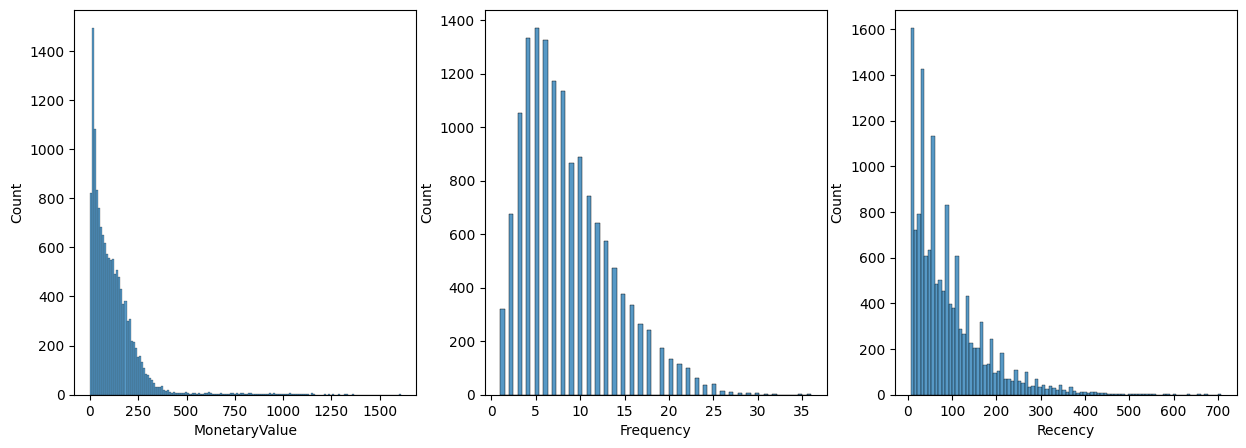

In [29]:
fig, ax = plt.subplots(1,3, figsize = (15,5))
sns.histplot(data=df_00, x="MonetaryValue", ax=ax[0])
sns.histplot(data=df_00, x="Frequency", ax=ax[1])
sns.histplot(data=df_00, x="Recency", ax=ax[2])

<Axes: xlabel='income', ylabel='Count'>

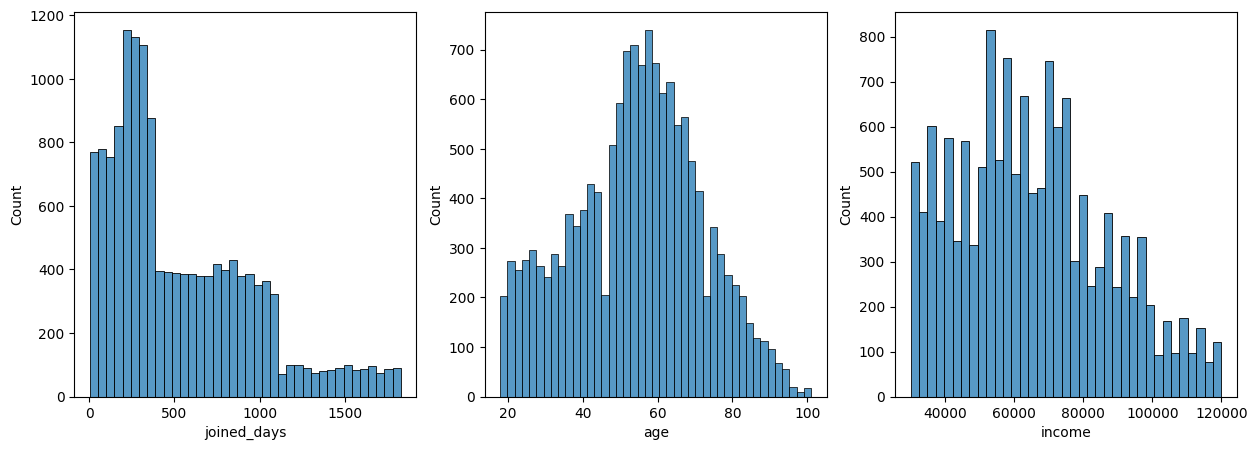

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=df_00, x="joined_days", ax=ax[0])
sns.histplot(data=df_00, x="age", ax=ax[1])
sns.histplot(data=df_00, x="income", ax=ax[2])

**The dataset is skewed and we must normalise it**

In [31]:
df_01 = df_00.copy()

In [32]:
cols_to_transform = ['MonetaryValue', 'Frequency', 'Recency', 'joined_days', 'age', 'income']

# Apply Box-Cox to each column
for col in cols_to_transform:
    df_01[col] = df_01[col] + 1  # Ensure all values are positive
    df_01[f"{col}_Transformed"], lambda_best = stats.boxcox(df_01[col])
    print(f"Optimal Lambda for {col}: {lambda_best}")

Optimal Lambda for MonetaryValue: 0.1708942132788271
Optimal Lambda for Frequency: 0.20582259342439546
Optimal Lambda for Recency: 0.1840896760779318
Optimal Lambda for joined_days: 0.33380711904837534
Optimal Lambda for age: 0.9997812804393477
Optimal Lambda for income: 0.28957680912008077


In [33]:
df_01 = df_01[
    [
        "gender_M",
        "gender_F",
        "MonetaryValue_Transformed",
        "Frequency_Transformed",
        "Recency_Transformed",
        "joined_days_Transformed",
        "age_Transformed",
        "income_Transformed",
    ]
]

df_01.head()

,gender_M,gender_F,MonetaryValue_Transformed,Frequency_Transformed,Recency_Transformed,joined_days_Transformed,age_Transformed,income_Transformed
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,0,7.567722,2.778250,4.392510,20.314210,32.981000,84.612795
0011e0d4e6b944f998e987f904e8c1e5,0,0,6.534260,2.166798,6.347507,14.683979,39.975455,78.852305
0020c2b971eb4e9188eac86d93036a77,0,1,8.593074,2.778250,3.278223,25.804337,58.959189,90.491184
0020ccbbb6d84e358d3414a3ff76cffd,0,1,8.003588,3.378686,5.688209,22.736833,23.987652,80.083922
003d66b6608740288d6cc97a6903f4f0,0,1,5.541230,4.047870,4.392510,19.250106,25.986227,84.965249


In [34]:
cols_to_scale = ['MonetaryValue_Transformed', 'Frequency_Transformed', 'Recency_Transformed', 'joined_days_Transformed', 'age_Transformed','income_Transformed']

sc = StandardScaler()
df_01[cols_to_scale] = sc.fit_transform(df_01[cols_to_scale])

df_01.head()

,gender_M,gender_F,MonetaryValue_Transformed,Frequency_Transformed,Recency_Transformed,joined_days_Transformed,age_Transformed,income_Transformed
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471
0011e0d4e6b944f998e987f904e8c1e5,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276
0020c2b971eb4e9188eac86d93036a77,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736
003d66b6608740288d6cc97a6903f4f0,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978


In [35]:
df_01.rename(
    columns={
        "MonetaryValue_Transformed" : "Monetary_Value",
        "Frequency_Transformed": "Frequency",
        "Recency_Transformed": "Recency",
        "joined_days_Transformed": "Joined_Days",
        "age_Transformed": "Age",
        "income_Transformed": "Income",
    },
    inplace=True,
)

In [36]:
df_01 = df_01.reset_index()
df_01.head()

,customer_id,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income
0,0009655768c64bdeb2e877511632db8f,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471
1,0011e0d4e6b944f998e987f904e8c1e5,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276
2,0020c2b971eb4e9188eac86d93036a77,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436
3,0020ccbbb6d84e358d3414a3ff76cffd,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736
4,003d66b6608740288d6cc97a6903f4f0,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978


In [37]:
df_01.columns

Index(['customer_id', 'gender_M', 'gender_F', 'Monetary_Value', 'Frequency',
       'Recency', 'Joined_Days', 'Age', 'Income'],
      dtype='object')

In [38]:
df_01 = df_01.drop(["customer_id"], axis=1)
df_01.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income
0,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471
1,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276
2,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436
3,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736
4,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978


# Perform K-Means Clustering

**Elbow Method**

In [88]:
X = df_01.copy()

In [89]:
X.isna().sum()

gender_M          0
gender_F          0
Monetary_Value    0
Frequency         0
Recency           0
Joined_Days       0
Age               0
Income            0
dtype: int64

In [90]:
# Range of k values to try
k_values = range(1, 20)
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS
    
    labels = kmeans.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X.values, labels)
        silhouette_scores.append(score)


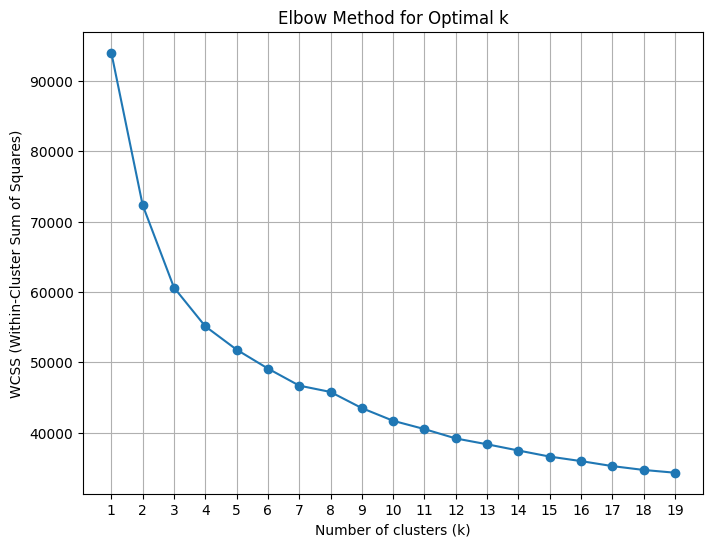

In [91]:
plt.figure(figsize=(8, 6))

plt.plot(k_values, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.xticks([x for x in k_values])
plt.grid(True)
plt.show()

In [92]:
silhouette_scores

[0.2148549643311243,
 0.19739796404422408,
 0.16978353316811876,
 0.159527366830998,
 0.14444828687683675,
 0.13767136658330878,
 0.13623689694233748,
 0.1337284711284292,
 0.13603892232312187,
 0.13709869631066385,
 0.13367026074080365,
 0.13321346908677814,
 0.13239857887799766,
 0.13357266656068548,
 0.1295750591978404,
 0.12751461425590221,
 0.12571848601046168,
 0.12730224240622087]

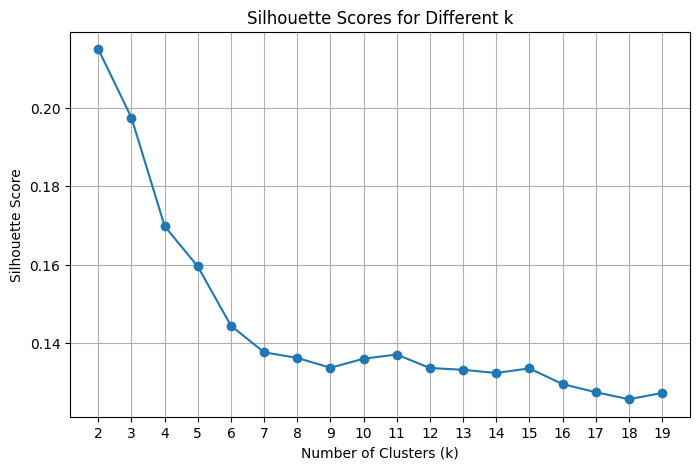

In [93]:
# Plot silhouette scores
k_range = range(2,20)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.xticks([x for x in k_range])
plt.grid(True)
plt.show()

**Fit The Model**

In [94]:
X = df_01.copy()
X.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income
0,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471
1,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276
2,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436
3,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736
4,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978


In [95]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(X)

KMeans(n_clusters=3, random_state=0)

In [96]:
X["Cluster"] = model.labels_

In [97]:
centroids = model.cluster_centers_

In [98]:
X.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income,Cluster
0,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471,0
1,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276,2
2,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436,1
3,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736,0
4,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978,0


**Snake Plot**

In [99]:
cols_to_plot = X.columns
cols_to_plot

Index(['gender_M', 'gender_F', 'Monetary_Value', 'Frequency', 'Recency',
       'Joined_Days', 'Age', 'Income', 'Cluster'],
      dtype='object')

In [100]:
X["Customer_id"] = df_00.index
X["Id"] = df_00.index
X = X.set_index(["Customer_id"])
X.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income,Cluster,Id
Customer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471,0,0009655768c64bdeb2e877511632db8f
0011e0d4e6b944f998e987f904e8c1e5,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276,2,0011e0d4e6b944f998e987f904e8c1e5
0020c2b971eb4e9188eac86d93036a77,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436,1,0020c2b971eb4e9188eac86d93036a77
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736,0,0020ccbbb6d84e358d3414a3ff76cffd
003d66b6608740288d6cc97a6903f4f0,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978,0,003d66b6608740288d6cc97a6903f4f0


In [101]:
cols_to_plot = ["Recency", "Frequency", "Monetary_Value"]

In [102]:
X_melted = pd.melt(X.reset_index(), 
        id_vars=["Id", "Cluster"], 
        value_vars=cols_to_plot, 
        var_name="Attribute",
        value_name="Value"
        )

X_melted.head()

,Id,Cluster,Attribute,Value
0,0009655768c64bdeb2e877511632db8f,0,Recency,-0.935490
1,0011e0d4e6b944f998e987f904e8c1e5,2,Recency,0.018582
2,0020c2b971eb4e9188eac86d93036a77,1,Recency,-1.479280
3,0020ccbbb6d84e358d3414a3ff76cffd,0,Recency,-0.303167
4,003d66b6608740288d6cc97a6903f4f0,0,Recency,-0.935490


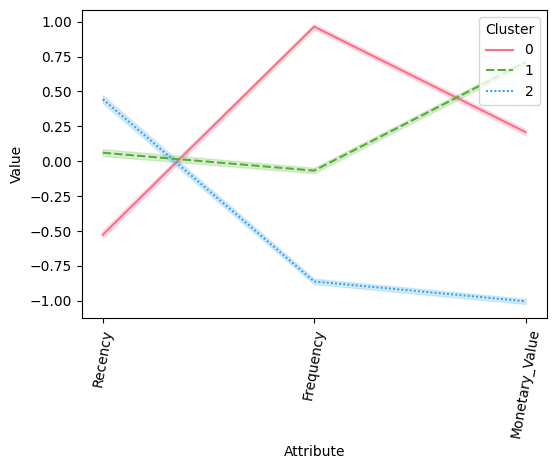

In [105]:
palette = sns.color_palette("husl", n_colors=X_melted["Cluster"].nunique())

plt.figure(figsize=(6,4))
sns.lineplot(data=X_melted, x = "Attribute", y = "Value", style="Cluster", palette=palette, hue="Cluster")
plt.xticks(rotation = 80)
plt.show()

* Cluster 0 - Made purchase more recently, most frequent, with a moderate amount (Loyal customers)
* Cluster 1 - Made recent purchase, are less frequent and spent most money (good customers)
* Cluster 2 - Made purchase long time ago, have lowest purchase frequency and spent lowest amount (lost customers)

**Cluster Visualization**

In [106]:
X.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income,Cluster,Id
Customer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471,0,0009655768c64bdeb2e877511632db8f
0011e0d4e6b944f998e987f904e8c1e5,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276,2,0011e0d4e6b944f998e987f904e8c1e5
0020c2b971eb4e9188eac86d93036a77,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436,1,0020c2b971eb4e9188eac86d93036a77
0020ccbbb6d84e358d3414a3ff76cffd,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736,0,0020ccbbb6d84e358d3414a3ff76cffd
003d66b6608740288d6cc97a6903f4f0,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978,0,003d66b6608740288d6cc97a6903f4f0


In [107]:
# 2D scatter plot (if you reduce dimensions)
X_ = X.drop(["Id"], axis=1)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_)
X_["pca1"] = X_pca[:, 0]
X_["pca2"] = X_pca[:, 1]

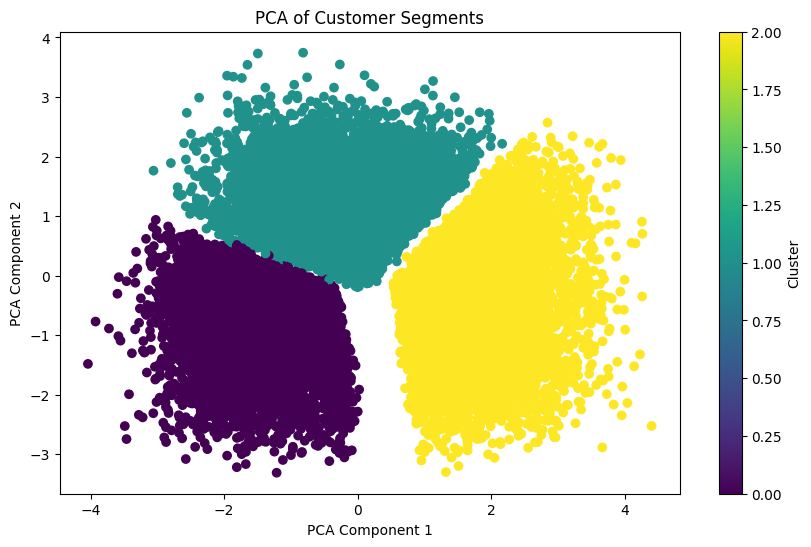

In [108]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_["pca1"], X_["pca2"], c=X_["Cluster"], cmap="viridis")
plt.colorbar(scatter, label="Cluster")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Customer Segments")
plt.show()

# Try PCA Before Clustering

In [109]:
X = df_01.copy()
X.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income
0,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471
1,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276
2,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436
3,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736
4,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978


In [110]:
# 2D scatter plot (if you reduce dimensions)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [111]:
# Range of k values to try
k_values = range(1, 20)
wcss = []
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    labels = kmeans.labels_
    if len(set(labels)) > 1:
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)

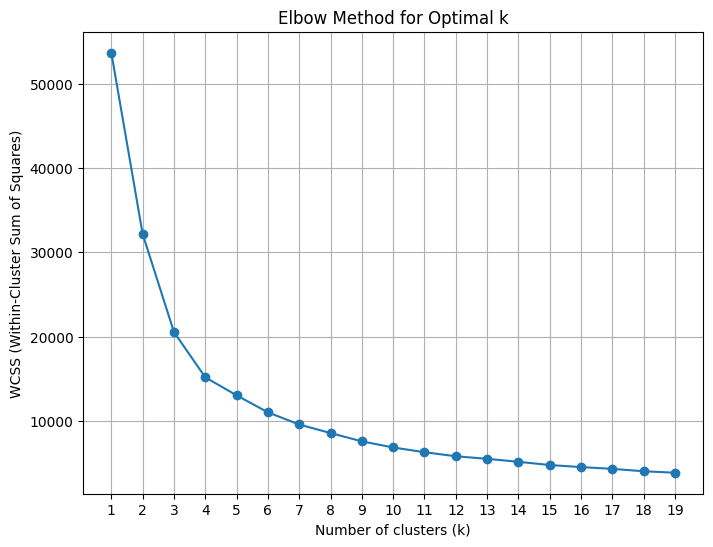

In [112]:
plt.figure(figsize=(8, 6))
plt.plot(k_values, wcss, marker="o")
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("WCSS (Within-Cluster Sum of Squares)")
plt.xticks([x for x in k_values])
plt.grid(True)
plt.show()

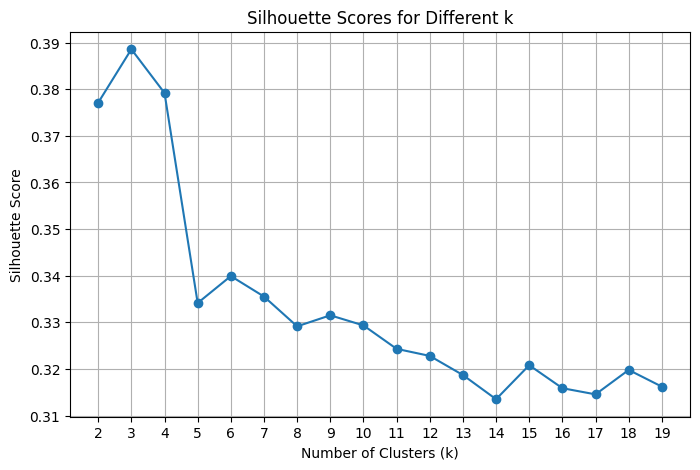

In [113]:
# Plot silhouette scores
k_range = range(2, 20)
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for Different k")
plt.xticks([x for x in k_range])
plt.grid(True)
plt.show()

**Fit the Model**

In [114]:
model = KMeans(n_clusters=3, random_state=0)
model.fit(X_pca)

KMeans(n_clusters=3, random_state=0)

In [115]:
clusters = model.labels_

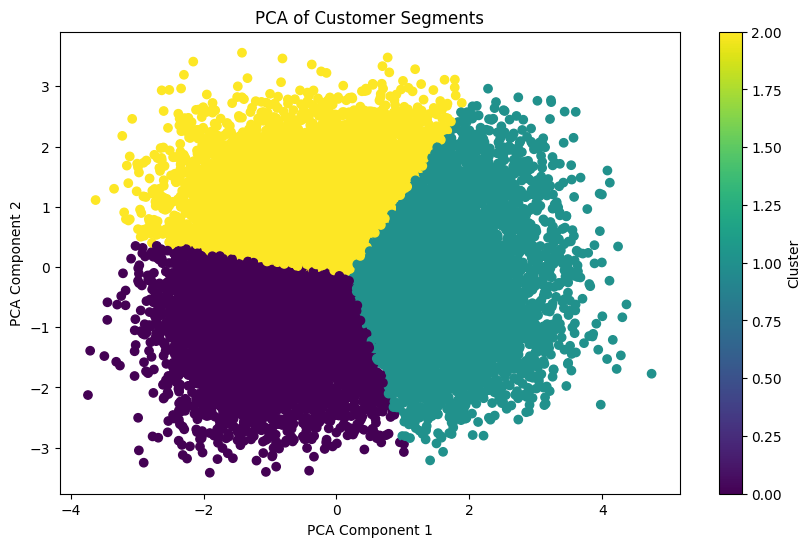

In [116]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap="viridis")
plt.colorbar(scatter, label="Cluster")

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA of Customer Segments")
plt.show()

**Snake Plot**

In [117]:
X["Cluster"] = clusters
X.head()

,gender_M,gender_F,Monetary_Value,Frequency,Recency,Joined_Days,Age,Income,Cluster
0,1,0,0.456879,0.098779,-0.935490,0.112615,-1.222092,0.418471,0
1,0,0,-0.014848,-0.620963,0.018582,-0.722035,-0.820554,-0.276276,1
2,0,1,0.924905,0.098779,-1.479280,0.926495,0.269265,1.127436,2
3,0,1,0.655832,0.805554,-0.303167,0.471755,-1.738383,-0.127736,0
4,0,1,-0.468121,1.593254,-0.935490,-0.045133,-1.623649,0.460978,0


In [118]:
X_melted = pd.melt(
    X.reset_index(),
    id_vars=["Cluster"],
    value_vars=cols_to_plot,
    var_name="Attribute",
    value_name="Value",
)

X_melted.head()

,Cluster,Attribute,Value
0,0,Recency,-0.935490
1,1,Recency,0.018582
2,2,Recency,-1.479280
3,0,Recency,-0.303167
4,0,Recency,-0.935490


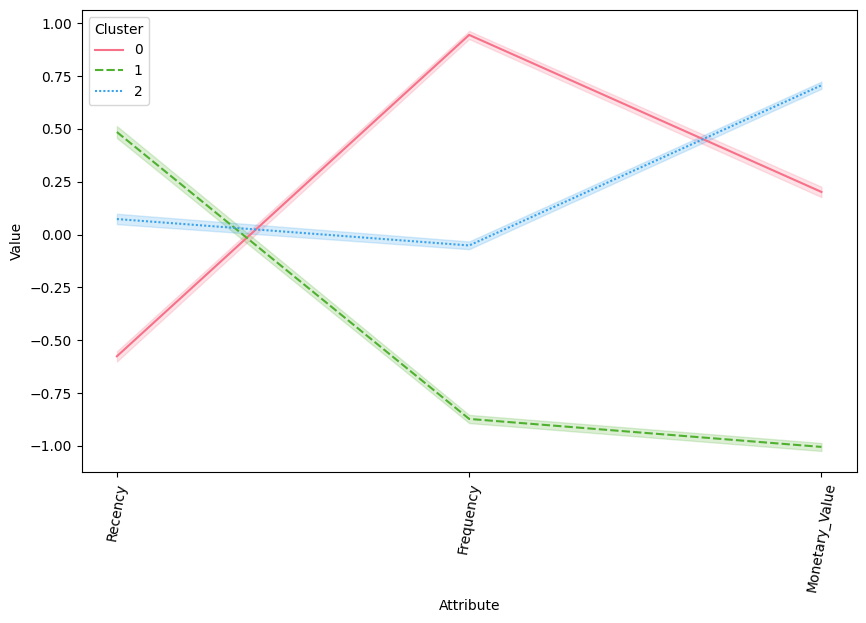

In [119]:
palette = sns.color_palette("husl", n_colors=X_melted["Cluster"].nunique())

plt.figure(figsize=(10, 6))
sns.lineplot(
    data=X_melted,
    x="Attribute",
    y="Value",
    style="Cluster",
    palette=palette,
    hue="Cluster",
)
plt.xticks(rotation=80)
plt.show()

**Recency vs Frequency**

In [120]:
df_00.head()

,MonetaryValue,Frequency,Recency,became_member_on,gender_M,gender_F,age,income,joined_days
customer_id,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,2017-04-21,1,0,33,72000.0,466
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,2018-01-09,0,0,40,57000.0,203
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,2016-03-04,0,1,59,90000.0,879
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,2016-11-11,0,1,24,60000.0,627
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,2017-06-21,0,1,26,73000.0,405


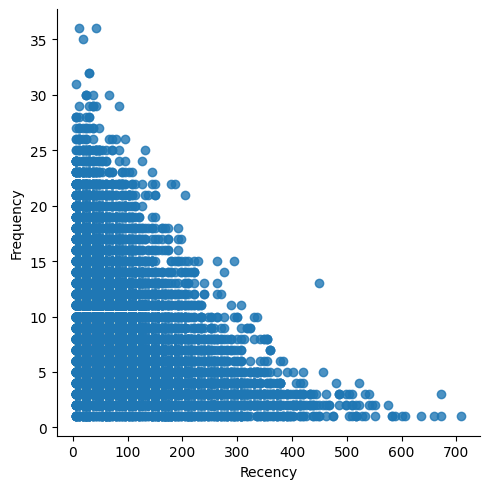

In [121]:
sns.lmplot(data = df_00, x = "Recency", y = "Frequency", fit_reg=False)

As recency increases, frequency decreases

**Monetary Value vs Frequency**

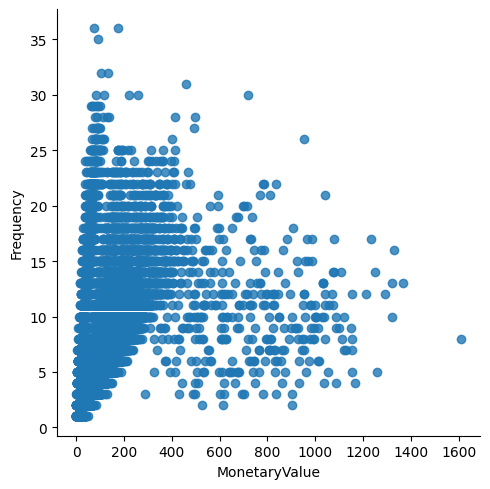

In [122]:
sns.lmplot(data=df_00, x="MonetaryValue", y="Frequency", fit_reg=False)

Customers who purchases more frequently spend less amount

**Monetary Value vs Recency**

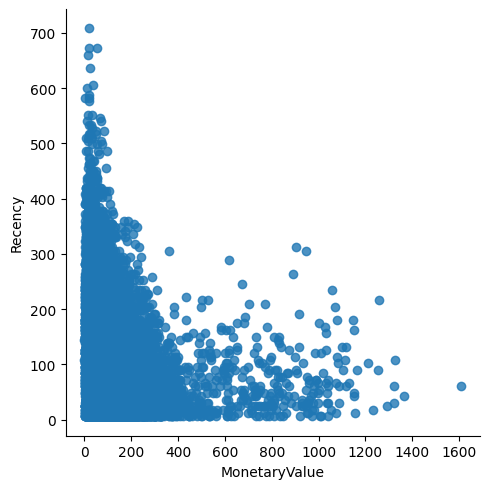

In [123]:
sns.lmplot(data=df_00, x="MonetaryValue", y="Recency", fit_reg=False)

A higher number of customers who made purchases recently spently small amount

# RFM Score

Score Each Metric by converting the RFM metrics into scores by binning the data.

In [124]:
def rfm_score(x, q1, q2, q3):
    """Return RFM score based on quartiles."""
    if x <= q1:
        return 5
    elif x <= q2:
        return 4
    elif x <= q3:
        return 3
    else:
        return 2

In [125]:
df_x = df_00[["MonetaryValue", "Frequency",	"Recency"]].copy()
df_x.head()

,MonetaryValue,Frequency,Recency
customer_id,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66
0020c2b971eb4e9188eac86d93036a77,196.86,8,12
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48
003d66b6608740288d6cc97a6903f4f0,48.34,18,24


In [126]:
# Calculate quartiles for scoring
recency_quartiles = df_x["Recency"].quantile([0.25, 0.5, 0.75])
frequency_quartiles = df_x["Frequency"].quantile([0.25, 0.5, 0.75])
monetary_quartiles = df_x["MonetaryValue"].quantile([0.25, 0.5, 0.75])

In [127]:
# Apply scoring
df_x["R_Score"] = df_x["Recency"].apply(
    rfm_score,
    args=(
        recency_quartiles[0.25], 
        recency_quartiles[0.5], 
        recency_quartiles[0.75]),
)

df_x["F_Score"] = df_x["Frequency"].apply(
    rfm_score,
    args=(
        frequency_quartiles[0.25],
        frequency_quartiles[0.5],
        frequency_quartiles[0.75],
    ),
)

df_x["M_Score"] = df_x["MonetaryValue"].apply(
    rfm_score,
    args=(monetary_quartiles[0.25], 
          monetary_quartiles[0.5], 
          monetary_quartiles[0.75]),
)

In [128]:
df_x.head()

,MonetaryValue,Frequency,Recency,R_Score,F_Score,M_Score
customer_id,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,5,3,3
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,4,5,4
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,5,3,2
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,4,2,3
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,5,2,4


**Combine Scores and Segment: Combine the individual scores into an overall RFM score and use it to segment customers.**

In [129]:
# Combine RFM scores into a single score
df_x["RFM_Segment"] = (
    df_x["R_Score"].astype(str) + df_x["F_Score"].astype(str) + df_x["M_Score"].astype(str)
)

In [130]:
# Segment customers based on RFM score
def segment_customer(rfm_score):
    if rfm_score == "555":
        return "Best Customers"
    elif rfm_score.startswith("5"):
        return "Loyal Customers"
    elif rfm_score.endswith("5"):
        return "High Value Customers"
    else:
        return "Others"

In [131]:
df_x["Segment"] = df_x["RFM_Segment"].apply(segment_customer)

In [132]:
df_x.head()

,MonetaryValue,Frequency,Recency,R_Score,F_Score,M_Score,RFM_Segment,Segment
customer_id,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,5,3,3,533,Loyal Customers
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,4,5,4,454,Others
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,5,3,2,532,Loyal Customers
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,4,2,3,423,Others
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,5,2,4,524,Loyal Customers


In [133]:
df_x['Segment'].value_counts()

Segment
Others                  7763
Loyal Customers         3518
High Value Customers    2912
Best Customers           299
Name: count, dtype: int64

In [134]:
df_x["RFM_Score"] = df_x[["R_Score", "F_Score", "M_Score"]].sum(axis=1)
df_x.head()

,MonetaryValue,Frequency,Recency,R_Score,F_Score,M_Score,RFM_Segment,Segment,RFM_Score
customer_id,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,5,3,3,533,Loyal Customers,11
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,4,5,4,454,Others,13
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,5,3,2,532,Loyal Customers,10
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,4,2,3,423,Others,9
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,5,2,4,524,Loyal Customers,11


In [135]:
# Create human friendly RFM labels
group_map = {
    r"[1-2][1-2]": "Hibernating",
    r"[1-2][3-4]": "At risk",
    r"[1-2]5": "Can't lose them",
    r"3[1-2]": "About to sleep",
    r"33": "Need attention",
    r"[3-4][4-5]": "Loyal customers",
    r"41": "Promising",
    r"51": "New customers",
    r"[4-5][2-3]": "Potential loyalists",
    r"5[4-5]": "Champions",
}

df_x["Group"] = df_x["R_Score"].map(str) + df_x["F_Score"].map(str)
df_x["Group"] = df_x["Group"].replace(group_map, regex=True)
df_x.head()

,MonetaryValue,Frequency,Recency,R_Score,F_Score,M_Score,RFM_Segment,Segment,RFM_Score,Group
customer_id,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,5,3,3,533,Loyal Customers,11,Potential loyalists
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,4,5,4,454,Others,13,Loyal customers
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,5,3,2,532,Loyal Customers,10,Potential loyalists
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,4,2,3,423,Others,9,Potential loyalists
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,5,2,4,524,Loyal Customers,11,Potential loyalists


In [136]:
# Create some human friendly labels for the scores
df_x["Score"] = "Green"
df_x.loc[df_x["RFM_Score"] > 5, "Score"] = "Bronze"
df_x.loc[df_x["RFM_Score"] > 7, "Score"] = "Silver"
df_x.loc[df_x["RFM_Score"] > 9, "Score"] = "Gold"
df_x.loc[df_x["RFM_Score"] > 10, "Score"] = "Platinum"

df_x.head()

,MonetaryValue,Frequency,Recency,R_Score,F_Score,M_Score,RFM_Segment,Segment,RFM_Score,Group,Score
customer_id,,,,,,,,,,,
0009655768c64bdeb2e877511632db8f,127.60,8,24,5,3,3,533,Loyal Customers,11,Potential loyalists,Platinum
0011e0d4e6b944f998e987f904e8c1e5,79.46,5,66,4,5,4,454,Others,13,Loyal customers,Platinum
0020c2b971eb4e9188eac86d93036a77,196.86,8,12,5,3,2,532,Loyal Customers,10,Potential loyalists,Gold
0020ccbbb6d84e358d3414a3ff76cffd,154.05,12,48,4,2,3,423,Others,9,Potential loyalists,Silver
003d66b6608740288d6cc97a6903f4f0,48.34,18,24,5,2,4,524,Loyal Customers,11,Potential loyalists,Platinum


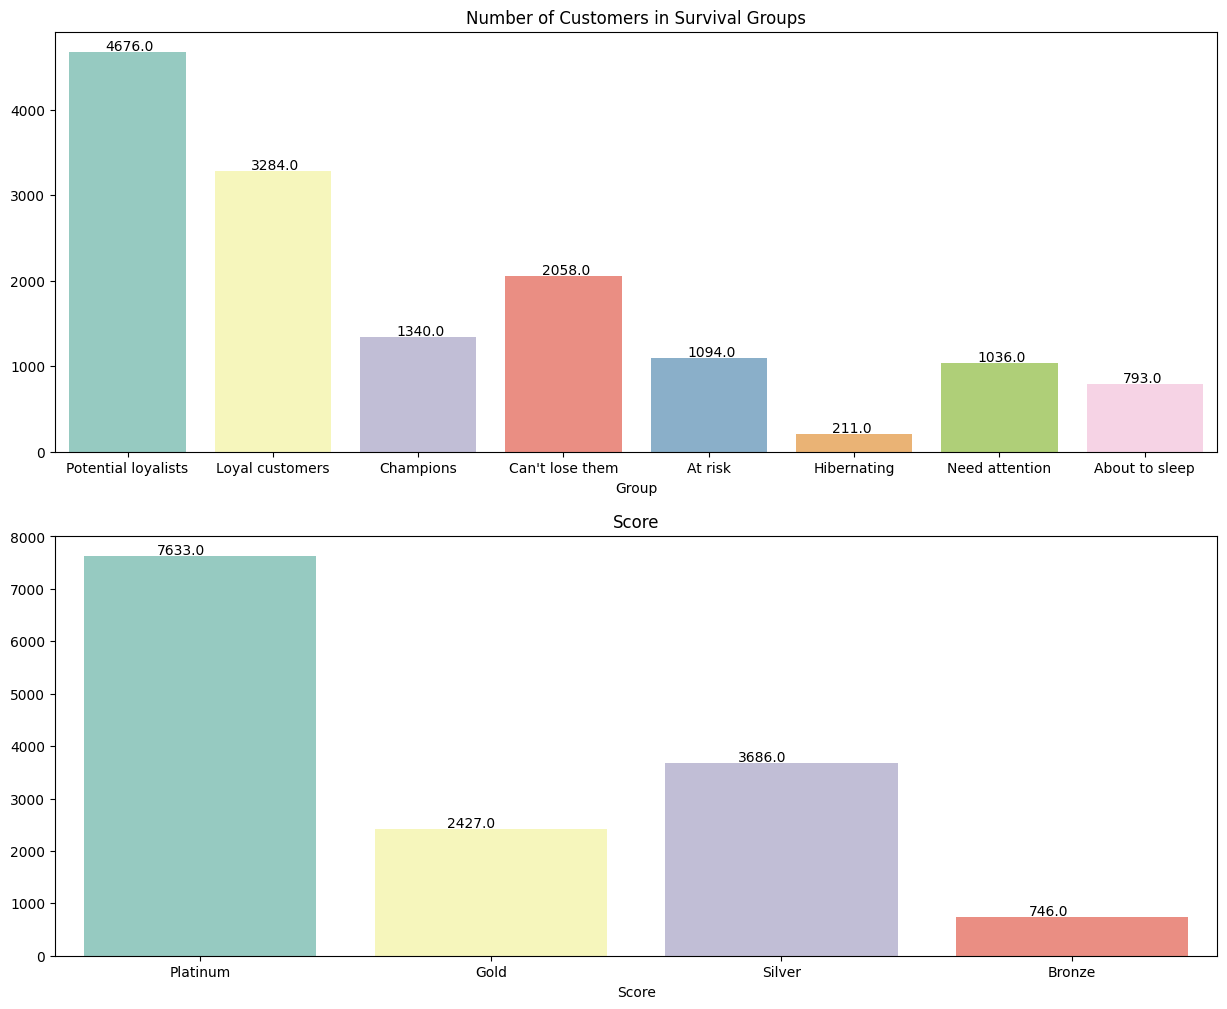

In [137]:
f, ax = plt.subplots(2, 1, figsize=(15, 12))
sns.countplot(data=df_x, x = "Group", ax=ax[0], palette="Set3", hue = "Group")
ax[0].set_title("Customer Group")
ax[0].set_ylabel("")
ax[0].set_title("Number of Customers in Survival Groups")
# ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

print("\n\n")
sns.countplot(data=df_x, x = "Score", ax=ax[1], palette="Set3", hue = "Score")
ax[1].set_title("Score")
ax[1].set_ylabel("")

for p in ax[0].patches:
    ax[0].annotate(
        "{:.1f}".format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 20)
    )

for p in ax[1].patches:
    ax[1].annotate(
        "{:.1f}".format(p.get_height()), (p.get_x() + 0.25, p.get_height() + 20)
    )

plt.show()